This notebook includes code to work with the filtered database to pre-process the signals within the filtered database so that the signals are ready for analysis

In [1]:
%run "Database_Filtering.ipynb" #allowing access to the filtered database

100%|████████████████████████████████████████████████████████████████████████████████| 549/549 [00:14<00:00, 38.19it/s]


The first step is to try to repeat the pre-processing done within the paper mentioned within my proposal:
https://www.nature.com/articles/s41598-017-15498-z#Bib1

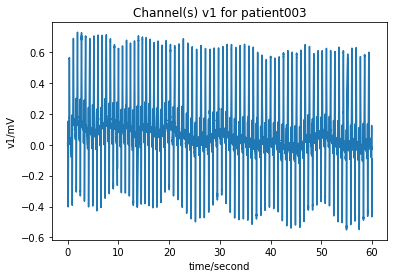

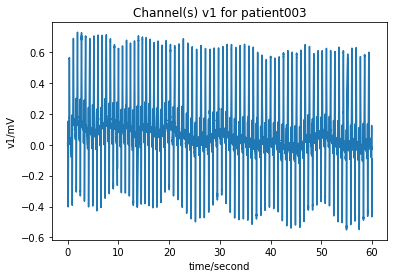

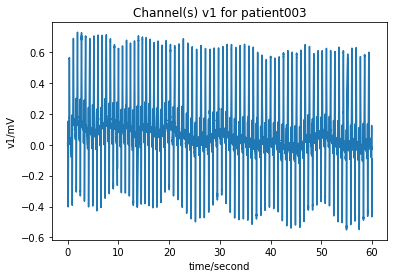

In [2]:
records = allowed_patients.get_records()
for i in range(0, 3):
    allowed_patients.get_patients(2).plot_channels(['v1'])
    
unhealthy_sig = allowed_patients.get_patients(2).read_signal(['v1'])

In [3]:
healthy_sig = allowed_patients.get_patients(180).read_signal(['v1'])


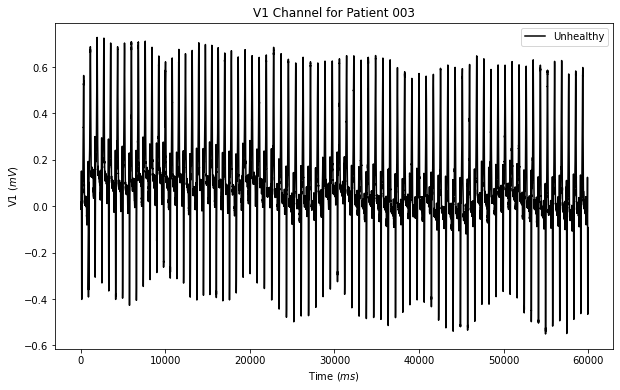

In [4]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))

ax.plot(unhealthy_sig[:60000], color = 'black', label = 'Unhealthy')
ax.set_xlabel(r'Time ($ms$)')
ax.set_ylabel(r'V1 ($mV$)')
ax.set_title('V1 Channel for Patient 003')
ax.legend()
plt.show()
#now have access to the signal data which is alot easier to manipulate

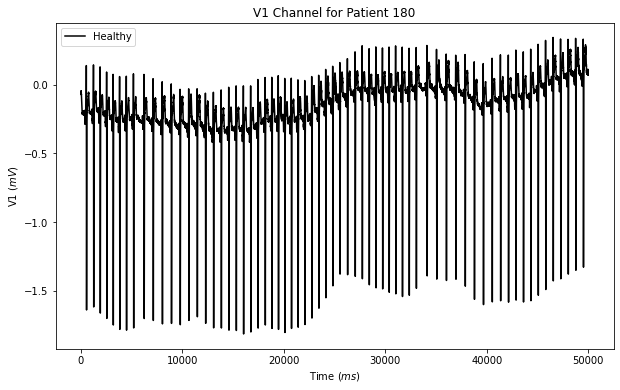

In [5]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))

x = np.linspace(0, 50, 50000)

ax.plot(healthy_sig[:50000], color = 'black', label = 'Healthy')
ax.set_xlabel(r'Time ($ms$)')
ax.set_ylabel(r'V1 ($mV$)')
ax.set_title('V1 Channel for Patient 180')

ax.legend()
plt.show()

## Polynomial Detrending

In [6]:
#have just done for v1 channel for now but can add implementation for all channels if required


In [7]:
def polynomial_detrending(signal, degree):
    x = np.linspace(0, len(signal), len(signal))
    
    coeffs = np.polyfit(x, signal, degree)
    trend = np.polyval(coeffs, x)
    
    return np.array(signal).reshape(-1) - np.array(trend), trend

In [8]:
no_patients = allowed_patients.count_patients()

detrended_signals = np.zeros(shape=(no_patients, sample_length))
signals = np.zeros(shape=(no_patients, sample_length))
trends = np.zeros(shape=(no_patients, sample_length))
for i in tqdm(range(0, no_patients)):
    signal = allowed_patients.get_patients(i).read_signal(['v1']).reshape(-1)
    signals[i] = signal
    detrended_signals[i], trends[i] = polynomial_detrending(signal, 8)
    
    

100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [00:06<00:00, 33.95it/s]


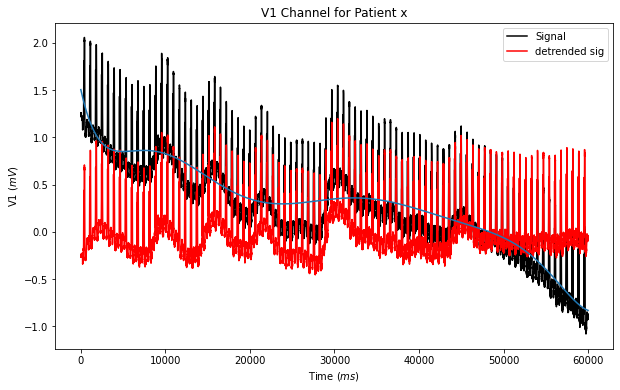

In [9]:
#fitting a trend to the da

fig, ax = plt.subplots(1, 1, figsize = (10, 6))


ax.plot(signals[0], color = 'black', label = 'Signal')
ax.plot(detrended_signals[0], color = 'red', label = 'detrended sig')
ax.plot(trends[0])

ax.set_xlabel(r'Time ($ms$)')
ax.set_ylabel(r'V1 ($mV$)')
ax.set_title('V1 Channel for Patient x')

ax.legend()
plt.show()

In [10]:
#can use other methods for the fitting?? rbf etc, always gonna have issues with this as shown above, can increase fitting
#degree but comes with other errors

## Wavelet Detrending  

In [11]:
import pywt

In [12]:
coeffs = pywt.wavedec(signals[0], wavelet='db4', level=3)  # decomposes to two levels, how many???

trend = coeffs[0]
#coeffs[-2] = np.zeros_like(coeffs[-2])
#coeffs[-1] = np.zeros_like(coeffs[-1])
coeffs[-4] = np.zeros_like(coeffs[-4])

print(coeffs)

detrended_signal_wavelet = pywt.waverec(coeffs, wavelet='db4')

#wavelet_detrended = signals[1] - interpolated_trend

[array([0., 0., 0., ..., 0., 0., 0.]), array([ 0.00169955,  0.00569793,  0.003488  , ..., -0.00308572,
        0.01316108, -0.02110592]), array([-0.00132152, -0.00390211,  0.0035093 , ...,  0.00357185,
        0.00389274, -0.01303062]), array([-0.00085548, -0.00153626,  0.0038352 , ...,  0.00240211,
        0.00615096, -0.00848074])]


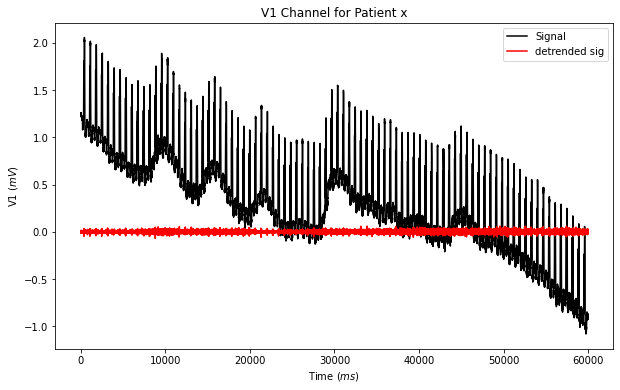

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))


ax.plot(signals[0], color = 'black', label = 'Signal')
ax.plot(detrended_signal_wavelet, color = 'red', label = 'detrended sig')
#ax.plot(interpolated_trend)

ax.set_xlabel(r'Time ($ms$)')
ax.set_ylabel(r'V1 ($mV$)')
ax.set_title('V1 Channel for Patient x')

ax.legend()
plt.show()

In [14]:
#is it not working because is mainly low frequency???

Need to balance signal denoising with preservation of signal features

## Butterworth filter

In [15]:
from scipy.signal import butter, filtfilt

In [16]:
# Define the cutoff frequency for the Butterworth filter
cutoff_freq = 1  # Adjust this value based on the characteristics of your signal

# Normalize the cutoff frequency
nyquist_freq = 500  # Nyquist frequency is half the sampling frequency
normalized_cutoff = cutoff_freq / nyquist_freq

# Design a low-pass Butterworth filter
order = 3  # Filter order
b, a = butter(order, normalized_cutoff, btype='low')

# Apply the filter to detrend the signal
detrended_signal_butter = filtfilt(b, a, signals[0])#thought this would give the detrended signal but gives a very good fit here
detrended_signal = signals[0]-detrended_signal_butter

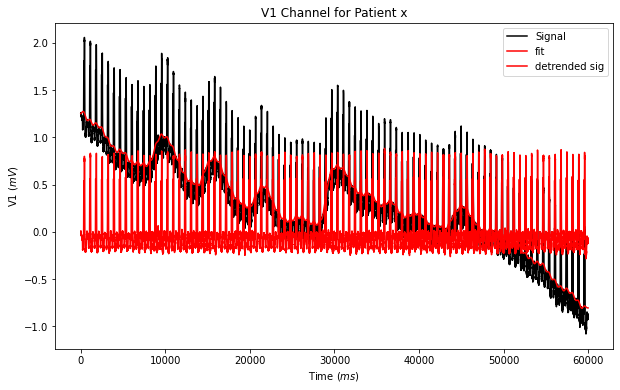

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))


ax.plot(signals[0], color = 'black', label = 'Signal')
ax.plot(detrended_signal_butter, color = 'red', label = 'fit')
ax.plot(detrended_signal, color = 'red', label = 'detrended sig')

ax.set_xlabel(r'Time ($ms$)')
ax.set_ylabel(r'V1 ($mV$)')
ax.set_title('V1 Channel for Patient x')

ax.legend()
plt.show()

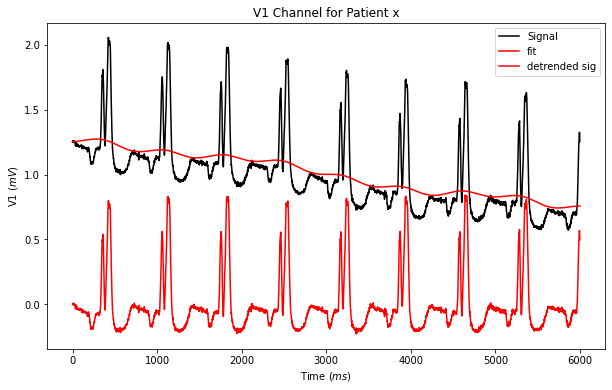

In [18]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))


ax.plot(signals[0][:6000], color = 'black', label = 'Signal')
ax.plot(detrended_signal_butter[:6000], color = 'red', label = 'fit')
ax.plot(detrended_signal[:6000], color = 'red', label = 'detrended sig')

ax.set_xlabel(r'Time ($ms$)')
ax.set_ylabel(r'V1 ($mV$)')
ax.set_title('V1 Channel for Patient x')

ax.legend()
plt.show()

In [19]:
def butterworth_detrending(signal, cut_off_freq, nyquist_freq, order):
    normalised_cut_off = cut_off_freq/nyquist_freq
    
    b, a = butter(order, normalized_cutoff, btype='low')

    baseline = filtfilt(b, a, signal)#thought this would give the detrended signal but gives a very good fit here
    detrended_signal = signal-baseline
    return detrended_signal, baseline

    

In [20]:
butterworth_detrended_signals = np.zeros(shape=(no_patients, sample_length))
trends = np.zeros(shape=(no_patients, sample_length))

for i, signal in enumerate(signals):
    butterworth_detrended_signals[i], trends[i] = butterworth_detrending(signal, cutoff_freq, nyquist_freq, order)

In [21]:
#still only on one singular channel


AttributeError: 'PatientCollection' object has no attribute 'get_diagnoses'